In [ ]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(maps)
library(ggrepel)
library(dendextend)

library(ggplot2)
library(maps)
library(FNN)
library(sp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



---------------------
Welcome to dendextend version 1.19.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:


In [ ]:
observations <- read.csv("../observations.csv")
observations <- observations %>%
  filter(Latitude >= 41 & Latitude <= 51,
         Longitude >= -5 & Longitude <= 10

In [12]:
stations = read.csv("../stations.csv")

Distribution de la température (seulement pour la France métropolitaine) ; nous pouvons observer une distribution qui ressemble à celle d'une loi normale

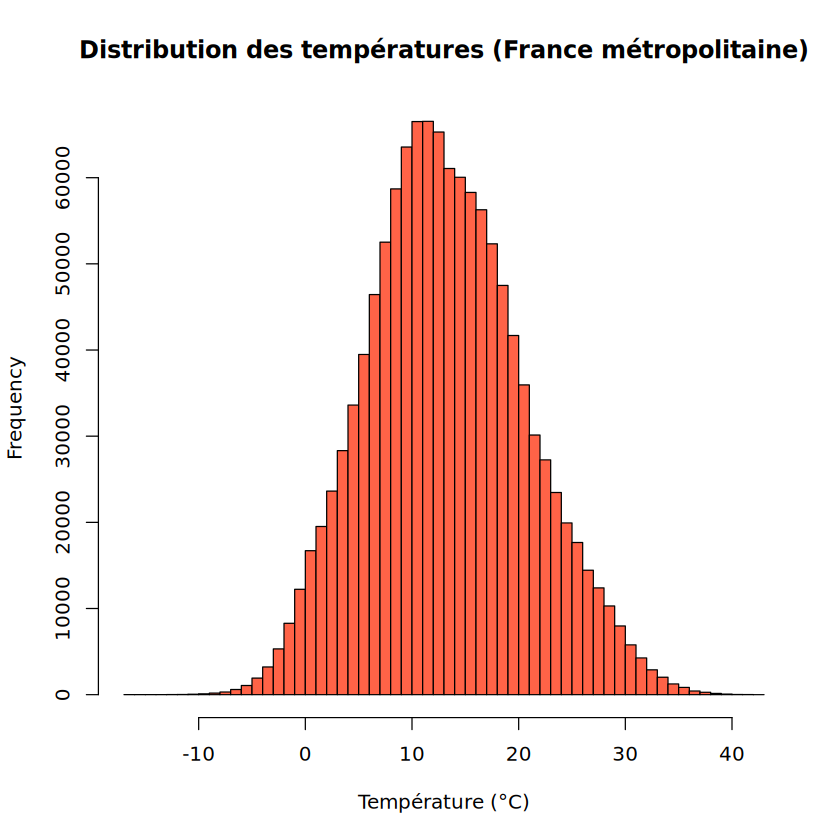

In [3]:
par(bg = 'white')
temp_C <- observations$Température - 273.15
hist(temp_C, breaks = 50, col = "tomato", main = "Distribution des températures (France métropolitaine)", xlab = "Température (°C)")

Distribution de la presion (seulement pour la France métropolitaine) ; cette fois-ci, pas de loi normale apparente

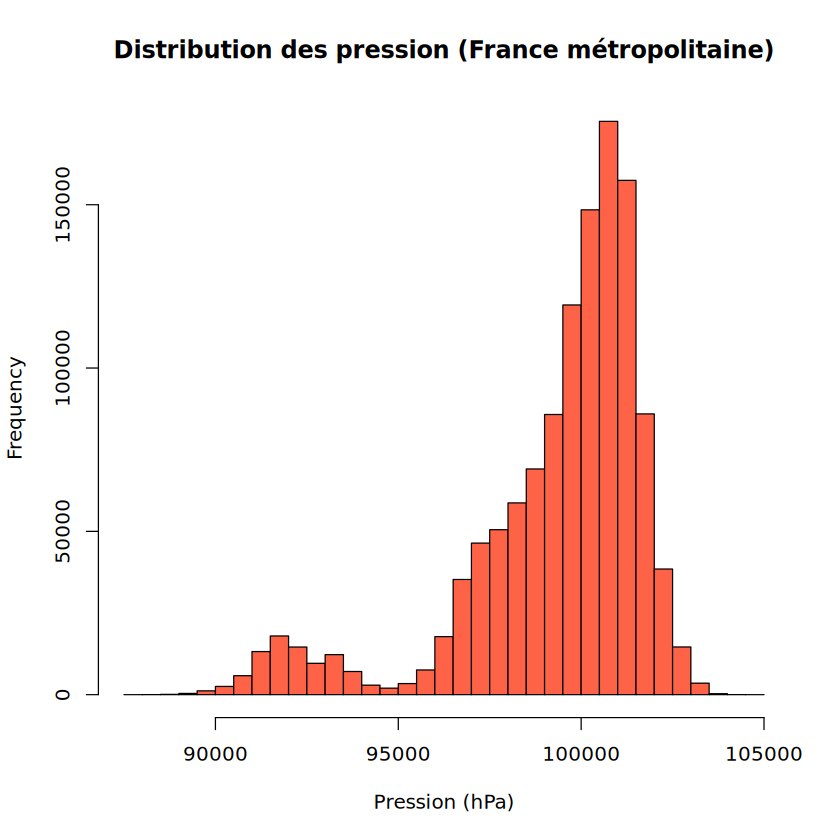

In [4]:
par(bg = 'white')
temp_C <- observations$Pression.station - 273.15
hist(temp_C, breaks = 50, col = "tomato", main = "Distribution des pression (France métropolitaine)", xlab = "Pression (hPa)")

Nous nous posons alors une première question : les températures au printemps et en automne ont-elles la même moyenne (sur toute la saison)?

Pour le vérifier, on fait un test avec t.test().

Nous observons une p-value très faible ($< 2.2 \times 10^{-16}$), ce qui indique que si elles avaient la même moyenne, on aurait une faible probabilité d'avoir ces observations.

In [5]:
spring <- subset(observations, mois_de_l_annee %in% c(4,5,6))$Température
fall <- subset(observations, mois_de_l_annee %in% c(9,10,11))$Température
print(cat("moyenne des température au printemps =", mean(spring, na.rm=TRUE)))
print(cat("moyenne des température en automne =", mean(fall, na.rm=TRUE)))
t.test(spring, mu = mean(fall, na.rm=TRUE))

moyenne des température au printemps = 288.5821NULL
moyenne des température en automne = 286.8119NULL



	One Sample t-test

data:  spring
t = 162.04, df = 298470, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 286.8119
95 percent confidence interval:
 288.5607 288.6035
sample estimates:
mean of x 
 288.5821 


Maintenant, on plot de l'évolution temporelle de la moyenne journalière de la moyenne des températures en France métropolitaine $T_{moy}(t)$ ; nous observons une sinusoïde, d'une période qui semble être d'un an.

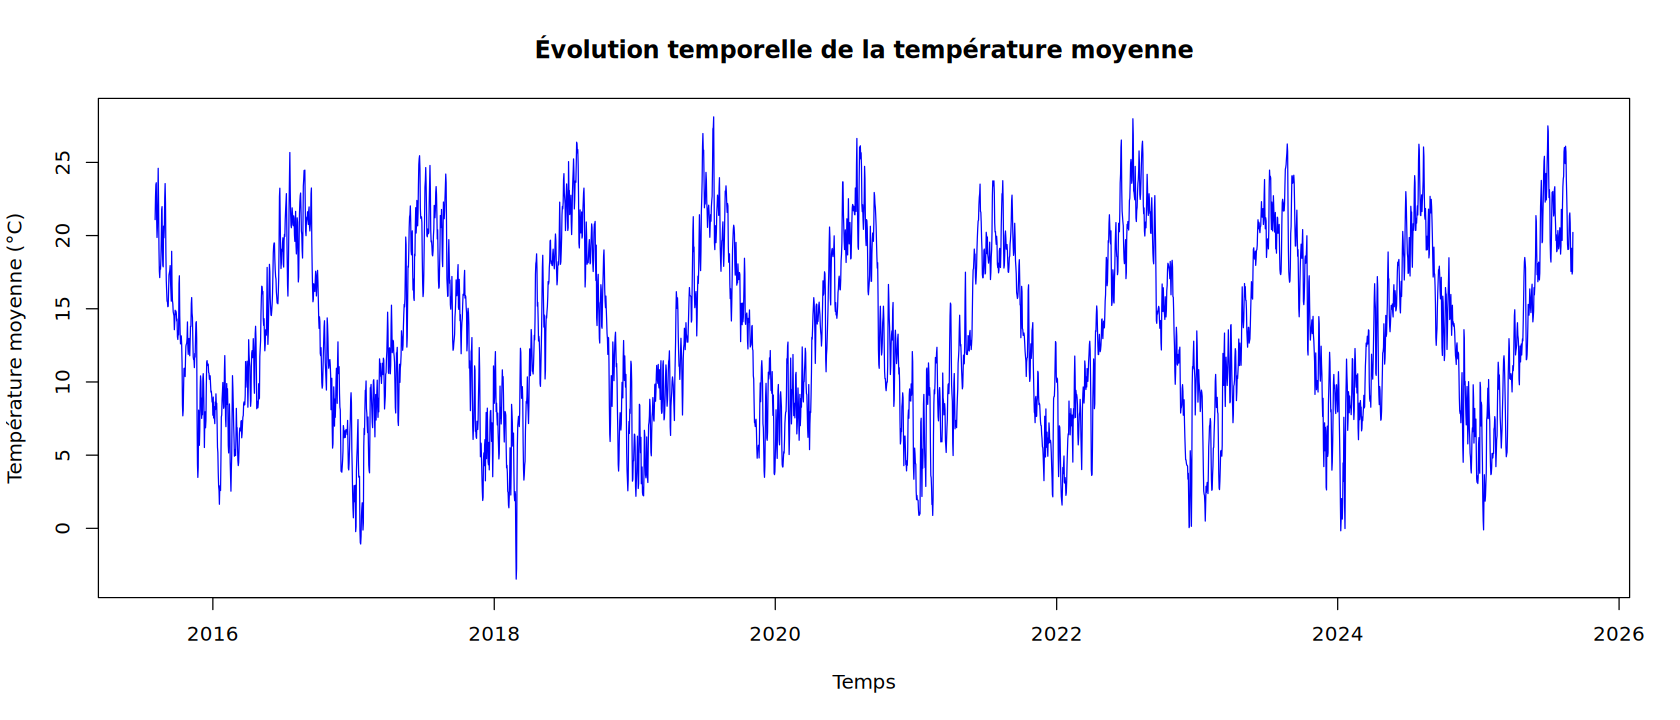

In [6]:
observations$Date <- as.POSIXct(observations$Date, format="%Y-%m-%dT%H:%M:%S", tz="UTC")
temp_jour <- observations %>%
  mutate(jour = as.Date(Date)) %>%
  group_by(jour) %>%
  summarise(temp_moy = mean(Température, na.rm = TRUE))

options(repr.plot.width=14, repr.plot.height=6)
par(bg = 'white')
plot(temp_jour$jour, temp_jour$temp_moy - 273.15, type="l",
     col="blue", xlab="Temps", ylab="Température moyenne (°C)",
     main="Évolution temporelle de la température moyenne")

Nous essayons d'estimer la période de $T_{moy}(t)$, avec la fonction nls() (nonlinear least squares) ; on retrouve bien environ 365 jours.

In [ ]:
temp_jour$t <- as.numeric(temp_jour$jour - min(temp_jour$jour))
fit_free <- nls(temp_moy ~ a + b * sin(2*pi*f*t + phi),
                data = temp_jour,
                start = list(a = mean(temp_jour$temp_moy, na.rm=TRUE),
                             b = 10,   # amplitude approx
                             f = 1/365, # fréquence initiale
                             phi = 0))
# summary(fit_free)
print(cat("période des varitions de température =", 1/coef(fit_free)["f"]))

Maintenant, nous séparons les températures (en France) en 4 groupes : les températures sur les périodes 2025-2027, 2018-2020, 2021-2023, et 2024. Nous cherchons à savoir si la température moyenne en France sur ces périodes a évoluée. Pour cela, nous effectuons une ANOVA.

Nous observons une p-value inférieure à $2 \times 10^{-16}$, ce qui indique que si les différents groupes avaient la même moyenne, on a une très faible probabilité d'avoir ces observations. En effet, on voit une légère augmentation de ces moyennes ; serait-ce dû au changement climatique ?

In [7]:
observations$annee <- year(as.Date(observations$Date))

observations$periode <- cut(observations$annee,
                            breaks = c(2014, 2017, 2020, 2023, 2026),
                            labels = c("2015-2017", "2018-2020", "2021-2023", "2024"))

moyennes_periode <- observations %>%
  group_by(periode) %>%
  summarise(temp_moy = mean(Température, na.rm = TRUE))

print(moyennes_periode)
anova_res <- aov(Température ~ periode, data = observations)
summary(anova_res)

# A tibble: 4 × 2
  periode   temp_moy
  <fct>        <dbl>
1 2015-2017     286.
2 2018-2020     287.
3 2021-2023     287.
4 2024          287.


                 Df   Sum Sq Mean Sq F value Pr(>F)    
periode           3    92372   30791   571.4 <2e-16 ***
Residuals   1208814 65137380      54                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
17973 observations deleted due to missingness

Maintenant, nous allons essayer de vérifier notre intuition que la distribution des températures suit une loi normale. Pour cela, nous mettons en place un test de Shapiro, à partir de 5000 températures tirées au hasard dans notre jeu de données (shapiro.test() n'autorise pas d'utiliser plus d'éléments).

La p-value de ce test est d'environ $4.5 \times 10^{-9}$, ce qui indique que si la distribution des tepératures suivait une loi normale, on aurait une faible probabilité d'avoir ces observations. Nous avons été quelque peu surpris, et nous avons quand même voulu tracer la distribution des 5000 températures prélevées.

Cela est sûrement dû au fait que l'observation d'une température à un moment donnée ne suit pas une loi normale de moyenne la moyenne totale des températures, mais dépend plutôt du jour de l'année et de l'heure d'observation.

Nous essayons alors autre chose : nous allons sélectionner les température pour un même jour sur plusieurs années (ici, ce sera le 21 décembre); pour chaque 21 décembre, nous faisons ensuite une moyenne de la température sur toute la journée. Finalement, on obtient 10 valeurs, à partir desquelles on va relancer un test de Shapiro. Nous obtenons alors une p-value de 0.06; toujours faible, donc.

In [8]:
set.seed(123)
temp_sample <- sample(observations$Température, 5000)
shapiro.test(temp_sample)


	Shapiro-Wilk normality test

data:  temp_sample
W = 0.99665, p-value = 4.533e-09


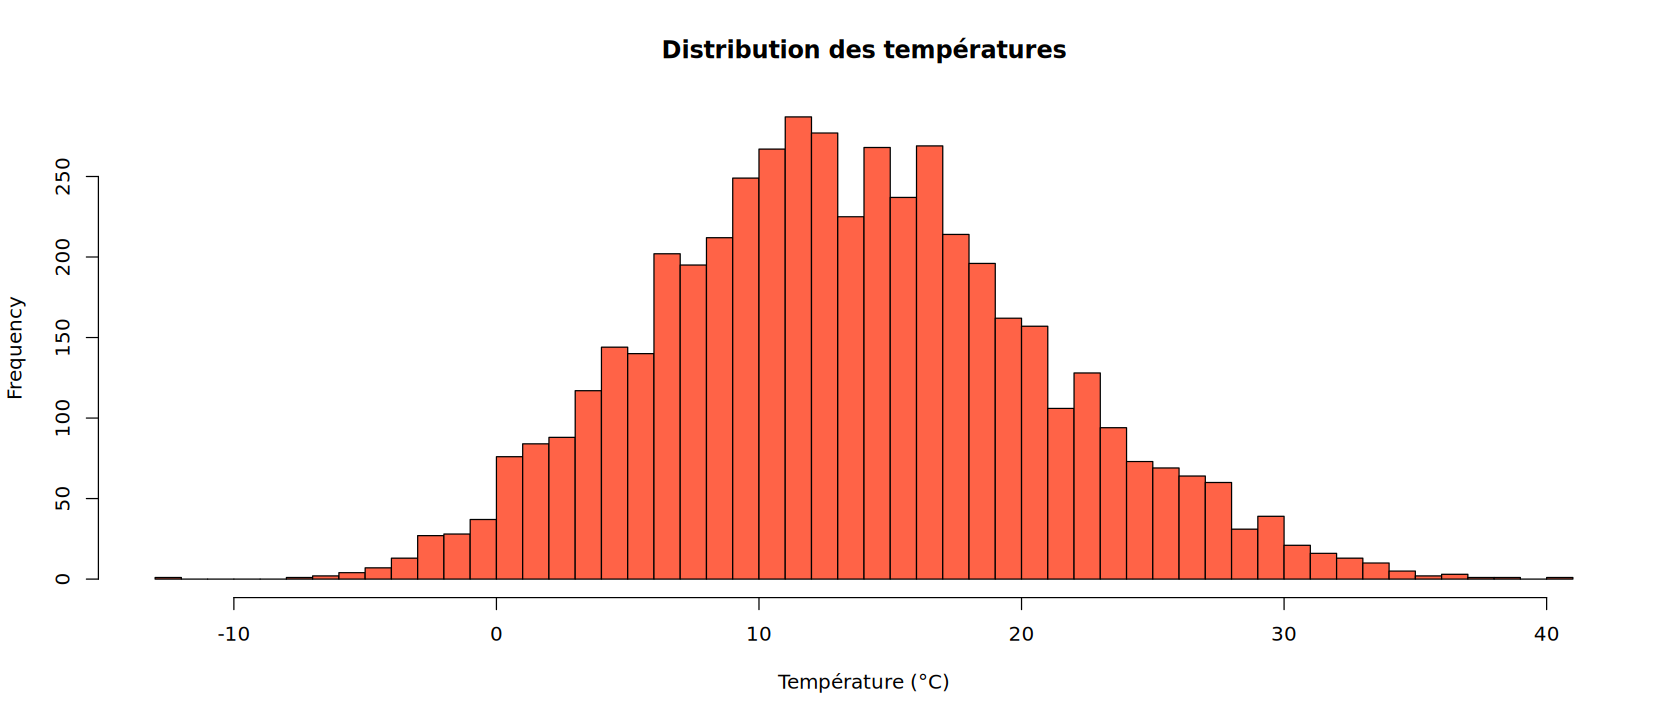

In [9]:
par(bg = 'white')
temp_sample_C <- temp_sample - 273.15
hist(temp_sample_C, breaks = 50, col = "tomato", main = "Distribution des températures", xlab = "Température (°C)")

In [10]:
observations$Date <- as.POSIXct(observations$Date,
                                format = "%Y-%m-%dT%H:%M:%S",
                                tz = "UTC")

temp_21dec <- observations %>%
  filter(format(Date, "%m-%d") == "12-21") %>%
  mutate(annee = format(Date, "%Y")) %>%
  group_by(annee) %>%
  summarise(temp_moy = mean(Température, na.rm = TRUE),
            .groups = "drop")

temp_21dec_moy <- temp_21dec$temp_moy
temp_21dec_moy <- scale(temp_21dec_moy)

shapiro.test(temp_21dec_moy)


	Shapiro-Wilk normality test

data:  temp_21dec_moy
W = 0.85084, p-value = 0.05944


L'objectif de cette section est d'essayer de retrouver les différents types de climats en France métropolitaine, à partir de notre jeu de données. Pour cela, nous effectuons un clustering sur les différentes stations, en des moyennes et écarts-types de différentes grandeurs (température, humidité, vent, précipitations, nébulosité).

Dans un premier temps, nous sélectionnons tout ça et mettons tout dans 'stations_france'.

In [13]:
stations_climat <- observations %>%
  group_by(ID.OMM.station, Latitude, Longitude, Altitude) %>%
  summarise(temp_moy = mean(Température, na.rm=TRUE),
            temp_sd = sd(Température, na.rm=TRUE),
            temp_ete = mean(Température[month(Date) %in% c(6,7,8)], na.rm=TRUE),
            temp_hiver = mean(Température[month(Date) %in% c(12,1,2)], na.rm=TRUE),
            hum_moy = mean(Humidité, na.rm=TRUE),
            hum_sd = sd(Humidité, na.rm=TRUE),
            vent_moy = mean(Vitesse.du.vent.moyen.10.mn, na.rm=TRUE),
            vent_sd = sd(Vitesse.du.vent.moyen.10.mn, na.rm=TRUE),
            precip_moy = mean(Précipitations.dans.les.24.dernières.heures, na.rm=TRUE),
            precip_sd = sd(Précipitations.dans.les.24.dernières.heures, na.rm=TRUE),
            nebul_moy = mean(Nebulosité.totale, na.rm=TRUE),
            .groups = "drop")

stations_climat <- stations_climat %>%
  left_join(stations %>% 
              select(ID.OMM.station, communes..name., department..name., region..name.),
            by = "ID.OMM.station")

stations_france <- stations_climat %>%
  filter(Latitude >= 42, Latitude <= 51,
         Longitude >= -5, Longitude <= 10)

head(stations_france)

ID.OMM.station,Latitude,Longitude,Altitude,temp_moy,temp_sd,temp_ete,temp_hiver,hum_moy,hum_sd,vent_moy,vent_sd,precip_moy,precip_sd,nebul_moy,communes..name.,department..name.,region..name.
<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
7005,50.13600,1.834000,69,284.7995,6.329857,291.1003,278.8929,80.33446,15.00129,3.600912,2.252659,2.194954,4.575288,72.55759,Abbeville,Somme,Hauts-de-France
7015,50.57000,3.097500,47,285.1373,6.913029,292.2792,278.5218,77.25565,17.06096,4.178517,2.452241,1.924008,4.172185,96.49914,Fretin,Nord,Hauts-de-France
7020,49.72517,-1.939833,6,285.9265,4.035360,289.8773,282.0276,81.67951,10.40275,6.758472,3.573506,2.088533,4.540331,69.14118,La Hague,Manche,Normandie
7027,49.18000,-0.456167,67,285.0625,6.023839,290.9454,279.6901,81.25286,13.97170,4.246815,2.474953,1.898839,4.056612,94.13673,Carpiquet,Calvados,Normandie
7037,49.38300,1.181667,151,284.6429,6.682290,291.3540,278.4196,79.98217,16.44134,4.039976,2.133913,2.130887,4.228155,94.67241,Boos,Seine-Maritime,Normandie
7072,49.20967,4.155333,95,284.8362,7.563019,292.4289,278.0861,78.50429,16.95049,3.138859,2.026884,1.598263,3.893918,97.29704,Prunay,Marne,Grand Est


On centre et réduit les grandeurs utilisées pour le clustering

In [14]:
data_scaled <- scale(stations_france %>% 
                         select(temp_moy, temp_sd, temp_ete, temp_hiver, hum_moy, hum_sd, vent_moy, vent_sd, precip_moy, precip_sd)
                    )
rownames(data_scaled) <- stations_france$communes..name.

On élabore maintenant un dendrogramme

Warning message in plot.window(...):
“"hang" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in title(...):
“"hang" is not a graphical parameter”


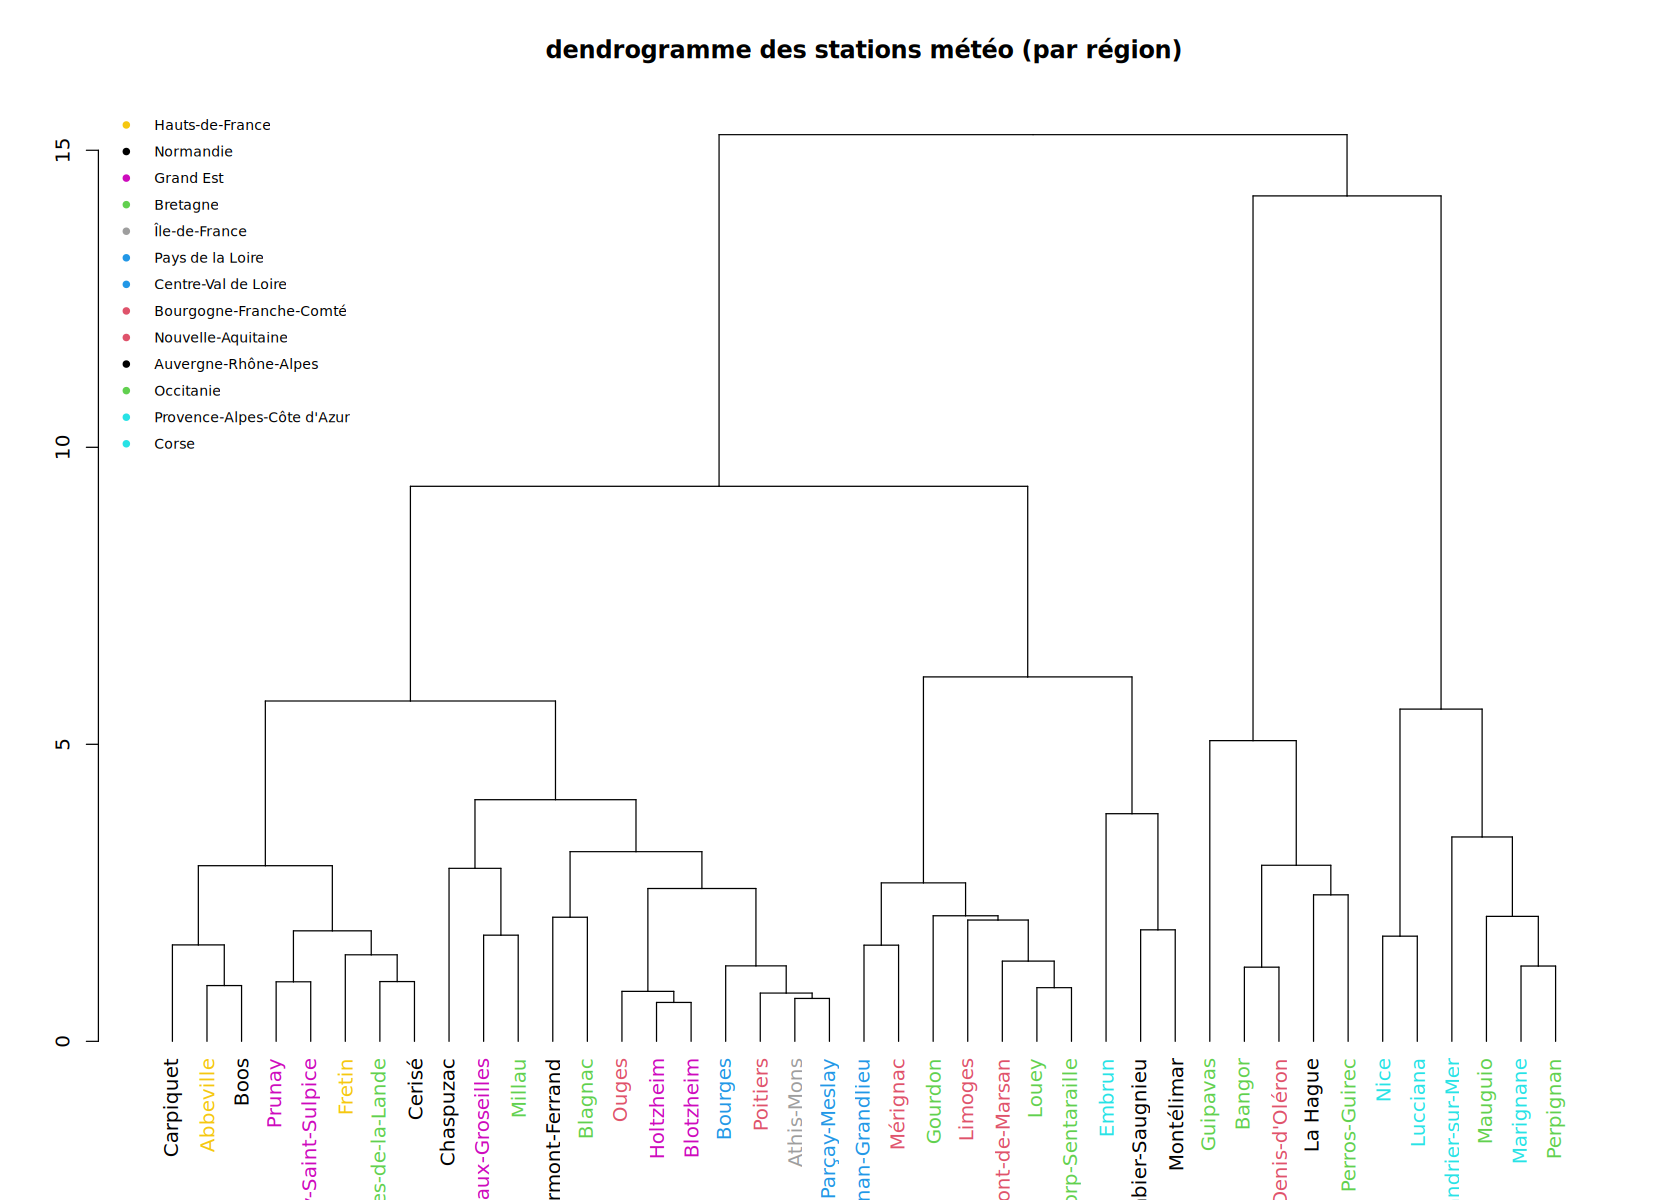

In [ ]:
d <- dist(data_scaled, method = "euclidean")
hc_res <- hclust(d, method = "ward.D2")

dend <- as.dendrogram(hc_res)
regions <- stations_france$region..name.
region_colors <- as.numeric(as.factor(regions))  # transforme chaque région en un code couleur
labels_colors(dend) <- region_colors[order.dendrogram(dend)] 

options(repr.plot.width=14, repr.plot.height=10) 
par(bg = 'white')
plot(dend, main = "dendrogramme des stations météo (par région)",
     cex = 0.6, hang = -1)

legend("topleft", legend = unique(regions),
       col = unique(region_colors), pch = 19, cex = 0.7, bty = "n")

Enfin, on plot les résultats sur la carte de la France métropolitaine

In [16]:
clusters_hc <- cutree(hc_res, k = 6)
stations_france$cluster <- factor(clusters_hc)

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


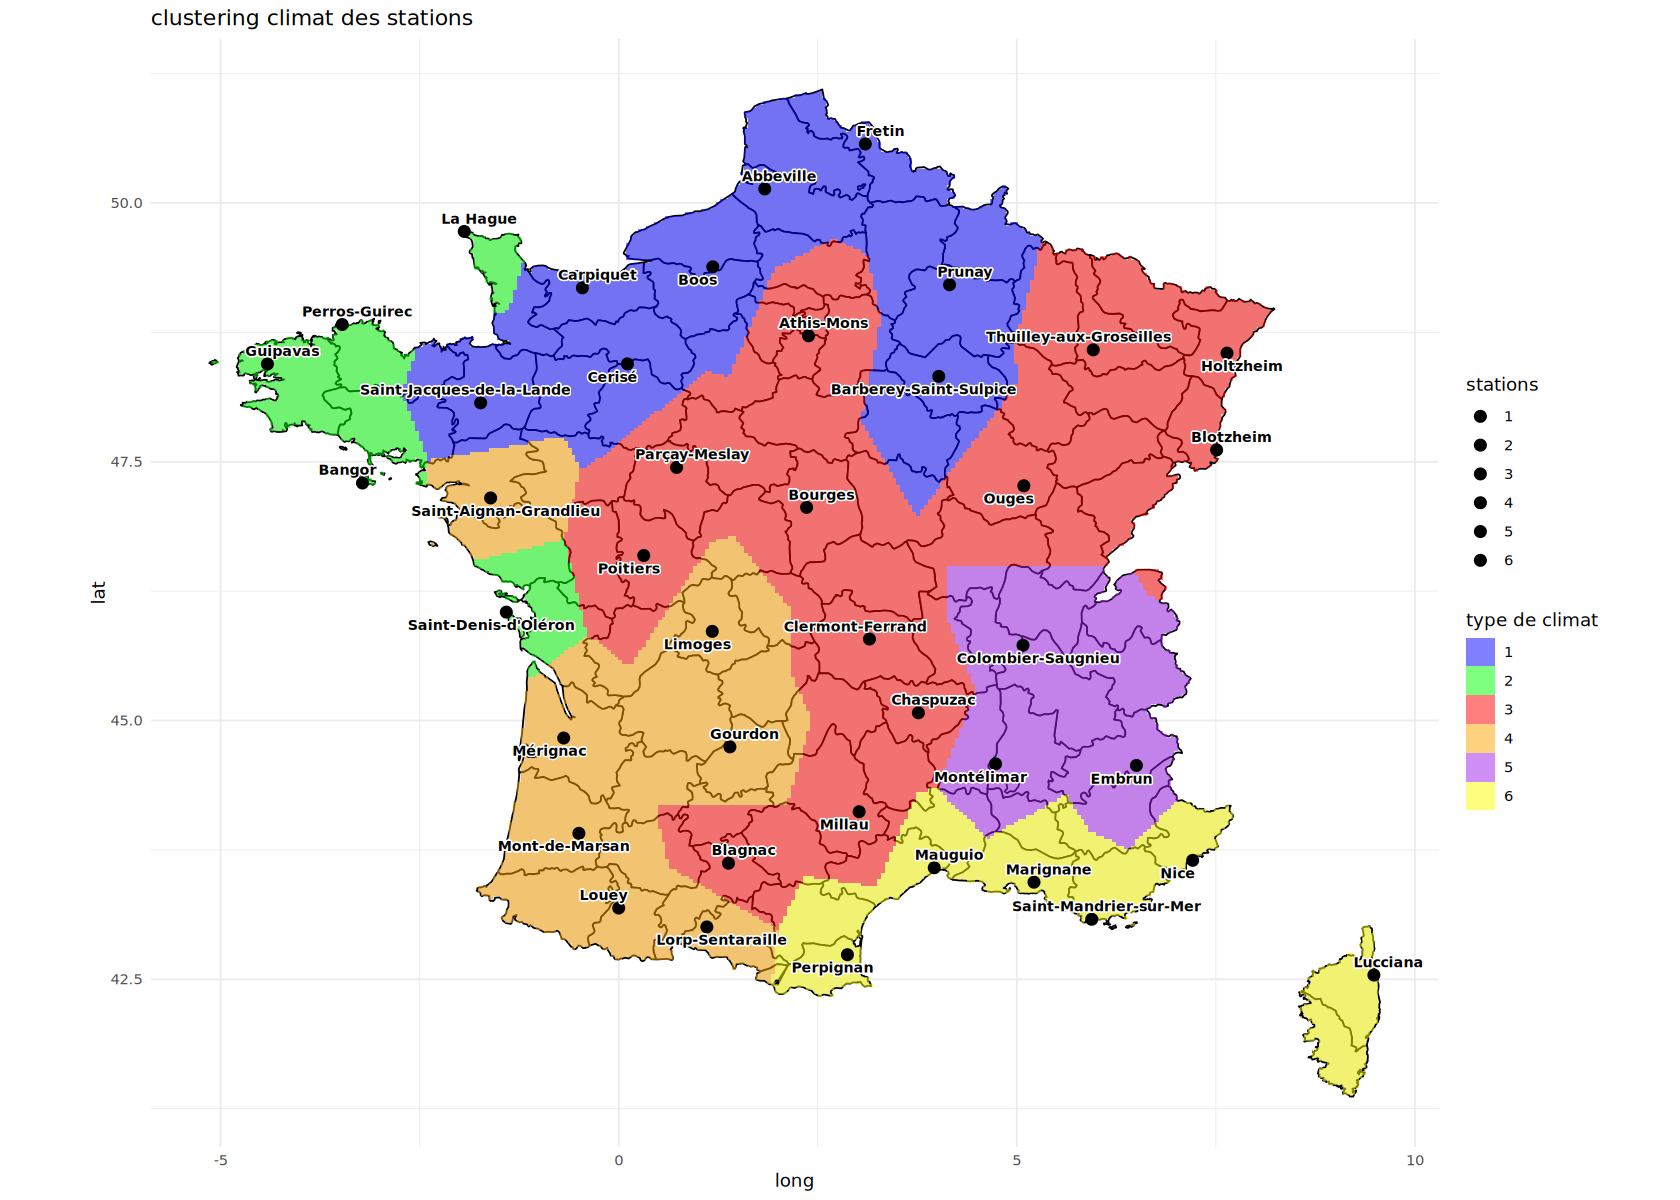

In [17]:
france_map <- map_data("france")

x_seq <- seq(min(france_map$long), max(france_map$long), length.out = 300)
y_seq <- seq(min(france_map$lat), max(france_map$lat), length.out = 300)
grid <- expand.grid(Longitude = x_seq, Latitude = y_seq)

inside_any <- rep(0, nrow(grid))

for(g in unique(france_map$group)){
  poly <- france_map[france_map$group == g, ]
  inside <- point.in.polygon(grid$Longitude, grid$Latitude,
                             poly$long, poly$lat)
  inside_any <- pmax(inside_any, inside)
}

grid <- grid[inside_any > 0, ]

nn <- get.knnx(stations_france[,c("Longitude","Latitude")], 
               grid, k = 1)
grid$cluster <- stations_france$cluster[nn$nn.index]

ggplot() +
  geom_polygon(data = france_map,
               aes(x = long, y = lat, group = group),
               fill = "grey90", color = "black") +
  geom_raster(data = grid,
              aes(x = Longitude, y = Latitude, fill = cluster),
              alpha = 0.5) +
  geom_point(data = stations_france,
             aes(x = Longitude, y = Latitude, color = cluster),
             size = 2) +
  
  geom_point(data = stations_france,
             aes(x = Longitude, y = Latitude, color = cluster),
             size = 3) +
  geom_text_repel(data = stations_france,
                  aes(x = Longitude, y = Latitude, 
                      label = communes..name., color = cluster),
                  size = 3, max.overlaps = 20,
                  fontface = "bold",
                  bg.color = "white", bg.r = 0.15) + # surlignage des textes
  
  coord_fixed(1.3, xlim = range(france_map$long), ylim = range(france_map$lat)) +
  theme_minimal() +
  labs(title = "clustering climat des stations",
       fill = "type de climat", color = "stations") +
  scale_fill_manual(values = c(
    "1" = "blue",
    "2" = "green",
    "3" = "red",
    "4" = "orange",
    "5" = "purple",
    "6" = "yellow"
  )) +
  scale_color_manual(values = c(
    "1" = "black",
    "2" = "black",
    "3" = "black",
    "4" = "black",
    "5" = "black",
    "6" = "black"
  ))
